<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/speech_activity_detection_pyannote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Activity Detection using Pyannote

Taken from here: https://github.com/pyannote/pyannote-audio

This expands the tutorials on their repo by extracting and plotting the speech, silence and full waveforms. 

### Note:

- Copy the audio files to your Drive. You cannot load from a Shared Drive. You can creat a shortcut to the shared drive in your drive and point to the shortcut.
- Pyannote may work better with audio files that are wav and 16khz, although they the pretrained models work on any file. You can resample them or convert to wav using unix commands like ffmpeg, but first try without.


In [ ]:
# Install packages not in Colab
!pip install -q pyannote.audio==1.1.2

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import google.colab
import torch
from IPython.display import Audio
from pyannote.audio.features import RawAudio
from pyannote.database.util import load_rttm
from pyannote.core import Segment, notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [ ]:
# config: depends whether you're on Google Colab or local

# On google colab
# Mount GDrive and attach it to the colab for data I/O
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_dir = '/content/drive/My Drive/my_notes/audio_samples/'
output_dir = '/content/drive/My Drive/my_notes/'

# Locally
# input_dir = './data/input/'
# output_dir = './data/output/'

# config
sr = 16000
fs = sr #different notation

# Simple Voice Activity Detection

In [ ]:
# load locally
# own_file, _ = google.colab.files.upload().popitem()
# notebook.reset()

# load from Google Drive
file_i = 'f2bjrop1.0.wav'
own_file = input_dir+file_i
OWN_FILE = {'audio': own_file}

# load audio waveform and play it
waveform = RawAudio(sample_rate=16000)(OWN_FILE).data
Audio(data=waveform.squeeze(), rate=16000, autoplay=False)

(0.0, 10.0)

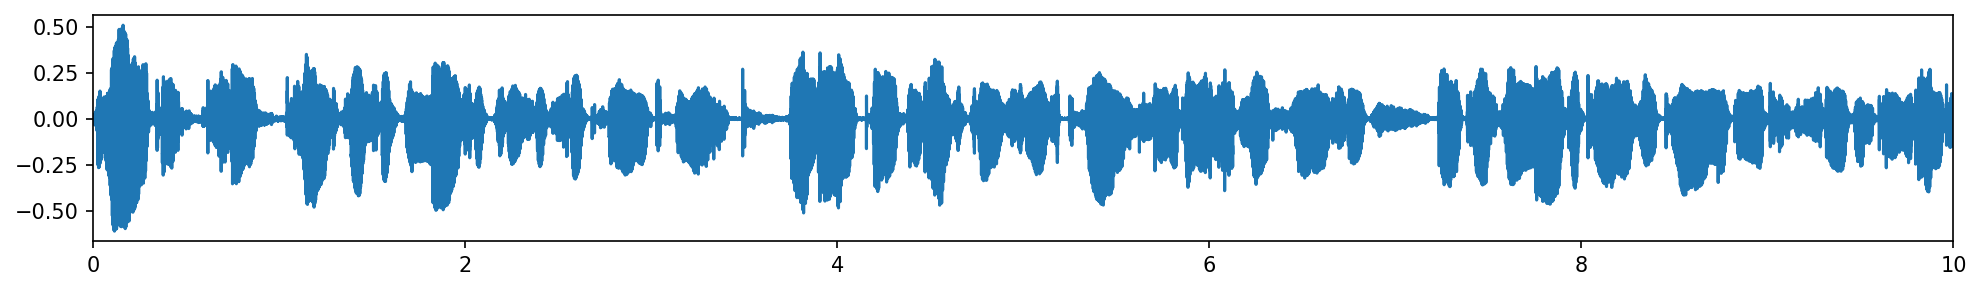

In [ ]:
# View waveform for the first 10 seconds
figure(figsize=(16, 2), dpi=150)
time = np.linspace(0, len(waveform) / fs, num=len(waveform))
plt.plot(time,waveform)
plt.xlim(0,10) #first 10 seconds

### Run VAD. Blue line below indicates degree of silence.

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


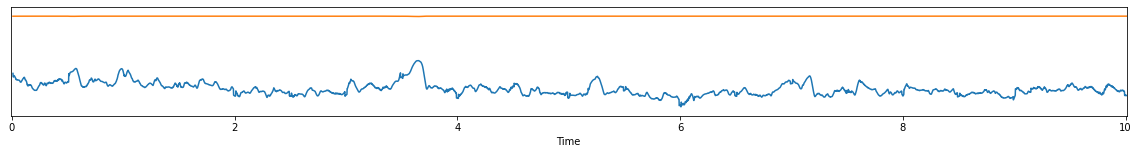

In [ ]:
# pre-trained models: https://github.com/pyannote/pyannote-audio-hub#speech-activity-detection
# speech activity detection model trained
sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')
sad_fit = sad(OWN_FILE)
EXCERPT = Segment(0, 10)
notebook.crop = EXCERPT
sad_fit

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


  0%|          | 0.00/2.41M [00:00<?, ?B/s]

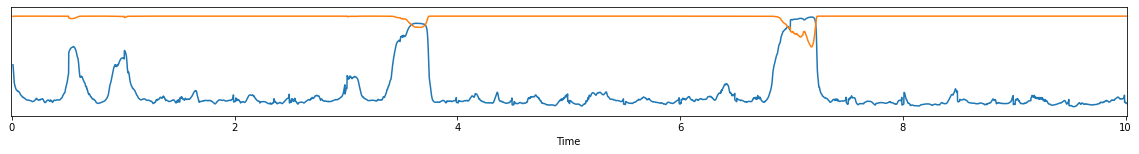

In [ ]:
# test sad
sad = torch.hub.load('pyannote/pyannote-audio', 'sad') # same as 'sad_dihard'
sad_fit = sad(OWN_FILE)
EXCERPT = Segment(0, 10)
notebook.crop = EXCERPT
sad_fit

## The sad/sad_dihard model seems to work a bit better than the sad_ami model in detecting sharpening the silence signal

In [ ]:
# # TODO: Plot from raw waveform data, the xticks are wrong
# sad = torch.hub.load('pyannote/pyannote-audio', 'sad', pipeline=False) #this needs to be False to get .data and make this plot.
# sad_fit = sad(OWN_FILE)
# figure(figsize=(16, 2), dpi=150)
# plt.plot(sad_fit.data)
# # plt.xlim(0,10)


# Create function to do VAD and return speech and silence segments

In [ ]:
def obtain_silences(speech_segments):
  silence_ends = [n[0] for n in speech_segments]
  silence_start = [n[1] for n in speech_segments]
  silence_segments = np.array([[0]+silence_start[:-1],silence_ends])
  silence_segments = pd.DataFrame(silence_segments).T.values #reshaped
  return silence_segments

In [ ]:
def speech_activity_detection(pipeline, path_to_wav, sr = 16000, return_silence_segments = True):
  """
  pipeline: for instance, pipeline = torch.hub.load('pyannote/pyannote-audio', 'sad', pipeline=True) 
  path_to_wav: single file
  sr = 16000
  return_silence_segments = True
  """
  
  OWN_FILE = {'audio': path_to_wav}
  # apply speech activity detection pipeline on your audio file
  sad = pipeline(OWN_FILE)
  speech_segments = []
  for speech_region in sad.get_timeline():
      # print(f'There is speech between t={speech_region.start:.1f}s and t={speech_region.end:.1f}s.')
      speech_segments.append([speech_region.start, speech_region.end])
  speech_segments = pd.DataFrame(speech_segments).values #reshaped
  if return_silence_segments:
    silence_segments = obtain_silences(speech_segments)
    return speech_segments, silence_segments
  else:
    return speech_segments, []


In [ ]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)





In [ ]:
files = os.listdir(input_dir)
files

['f2bjrop1.0.wav', 'f2bjrop1.1.wav', 'f2btrop6.0.wav']

In [ ]:
len(files)

3

In [ ]:
run_sad = True 


if run_sad:
  model = torch.hub.load('pyannote/pyannote-audio', 'sad')
  # load model and wrap it in a pipeline
  pipeline = torch.hub.load('pyannote/pyannote-audio', 'sad', pipeline=True)

  speech = {}
  silences = {}

  for i, file_i in enumerate(files):
    print(i)
    path_to_wav = input_dir+file_i
    speech_segments, silence_segments = speech_activity_detection(pipeline, path_to_wav, sr = 16000, return_silence_segments = True)
    speech[file_i]=speech_segments
    silences[file_i]=silence_segments
  
  # save in case you have many files, so you don't have to re-run each time
  json.dump(speech, open( output_dir+"vad_speech_segments.json", 'w' ) ,cls=NumpyEncoder)
  json.dump(silences, open( output_dir+"vad_silence_segments.json", 'w' ) ,cls=NumpyEncoder)

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


0
1
2


In [ ]:
# # Read data from file:

silence = json.load( open(output_dir+"vad_silence_segments.json" ) )
speech = json.load( open(output_dir+"vad_speech_segments.json" ) )
speech.values()

dict_values([[[0.01015625, 3.58428125], [3.71590625, 6.99134375], [7.219156249999999, 11.13246875]], [[0.01015625, 1.3517187499999999], [1.78878125, 9.20871875], [9.72509375, 11.682593749999999]], [[0.13334375, 3.61128125], [3.88803125, 7.99203125]]])

# Plot full waveform, speech waverform, and silence waveform

### This is useful

$seconds = \frac{samples}{sr}$

where $sr$ is sampling rate.


$samples = seconds \times sr$




In [ ]:
def concat_seconds(waveform, second_segments, sr = 16000):
  # crop waveform (one dimensional) according to second_segments [[1.2, 1.5],[2.1, 3.2], ...] 
  waveform = waveform.flatten()
  waveform_new = []
  samples = np.array(second_segments)*sr #convert to samples
  samples = samples.astype(int)

  for segment in samples:
    segment_data = waveform[segment[0]:segment[1]]
    waveform_new.extend(segment_data)
  return np.array(waveform_new)



In [ ]:
print(silence.get(file_i))
waveform_silence = concat_seconds(waveform, silence.get(file_i), sr = sr)

print('resulting waveform:', waveform_silence)

[[0.0, 0.13334375], [3.61128125, 3.88803125]]
resulting waveform: [-0.01959229 -0.01760864 -0.01525879 ...  0.00354004 -0.00259399
 -0.0111084 ]


f2bjrop1.0.wav


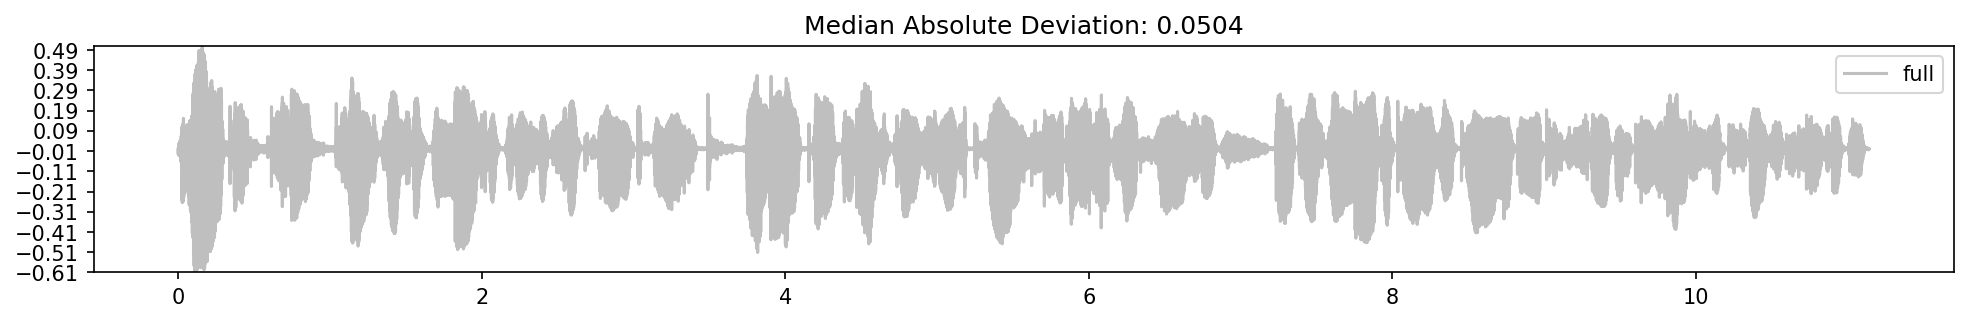

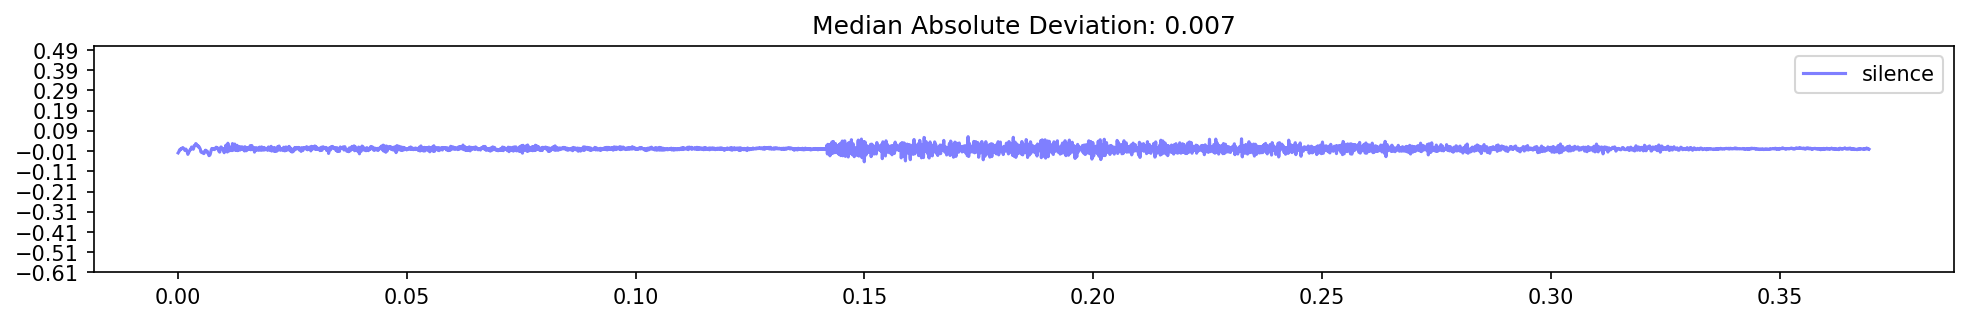

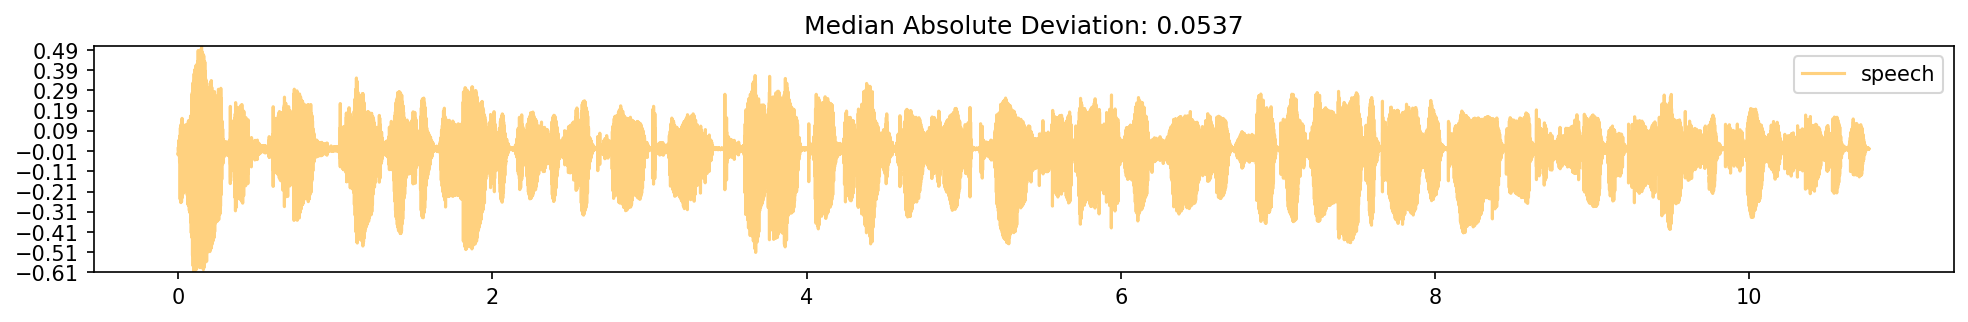




f2bjrop1.1.wav


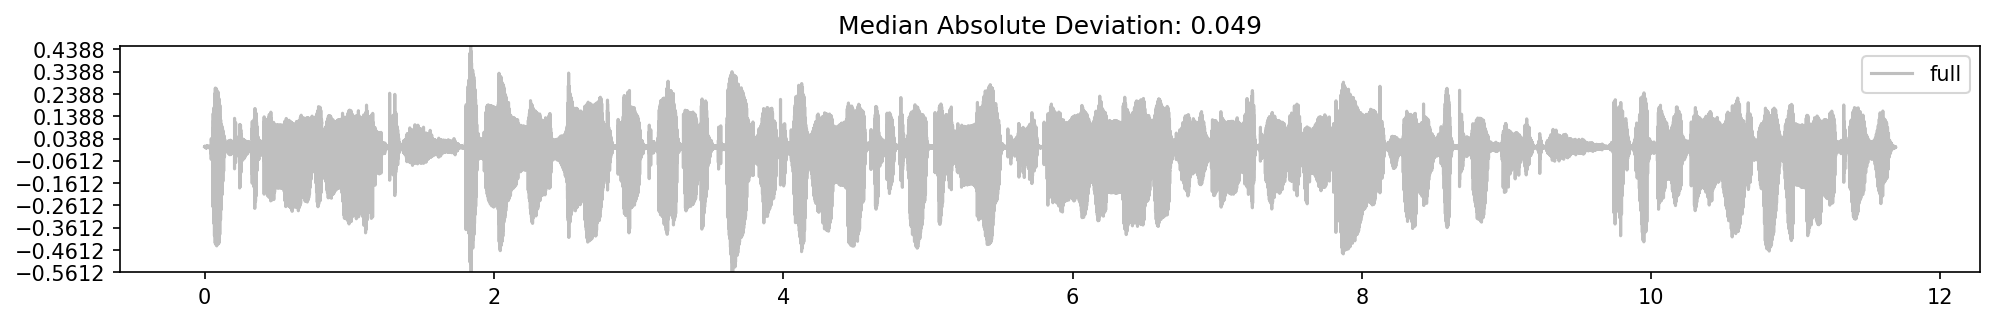

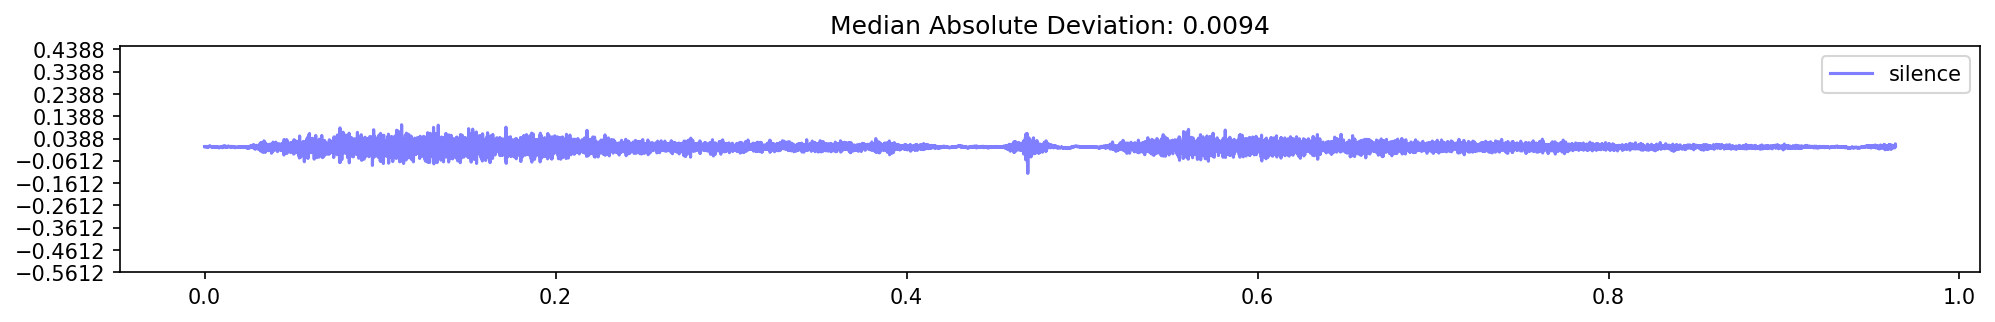

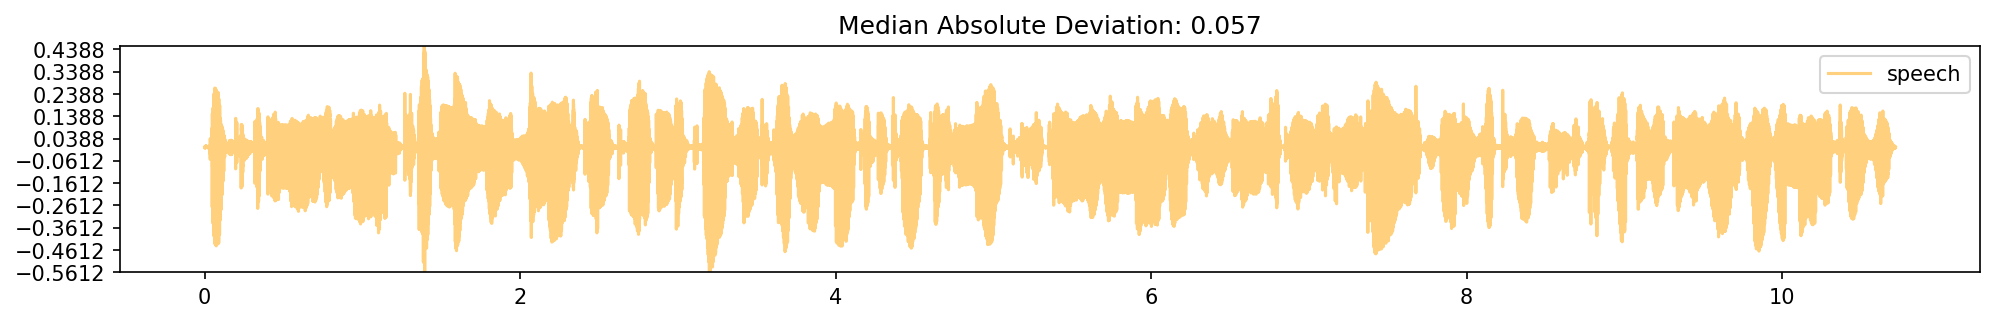




f2btrop6.0.wav


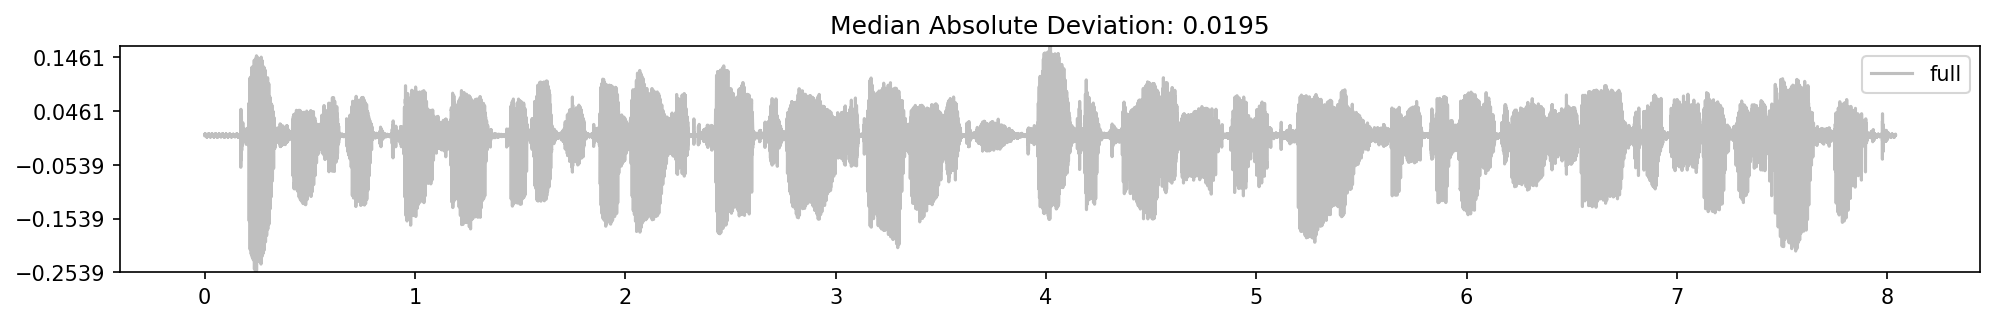

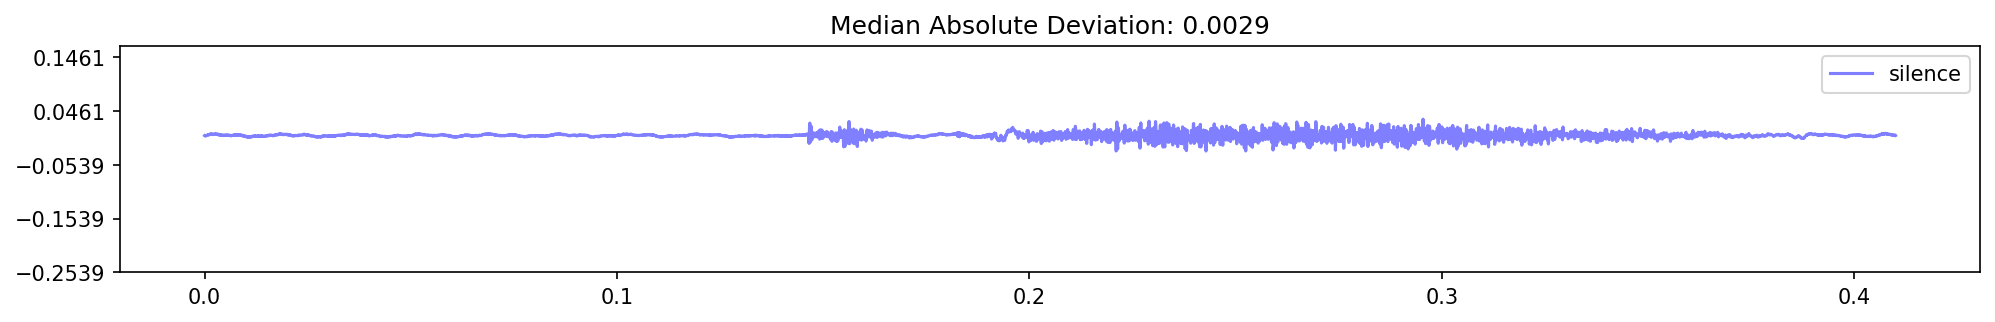

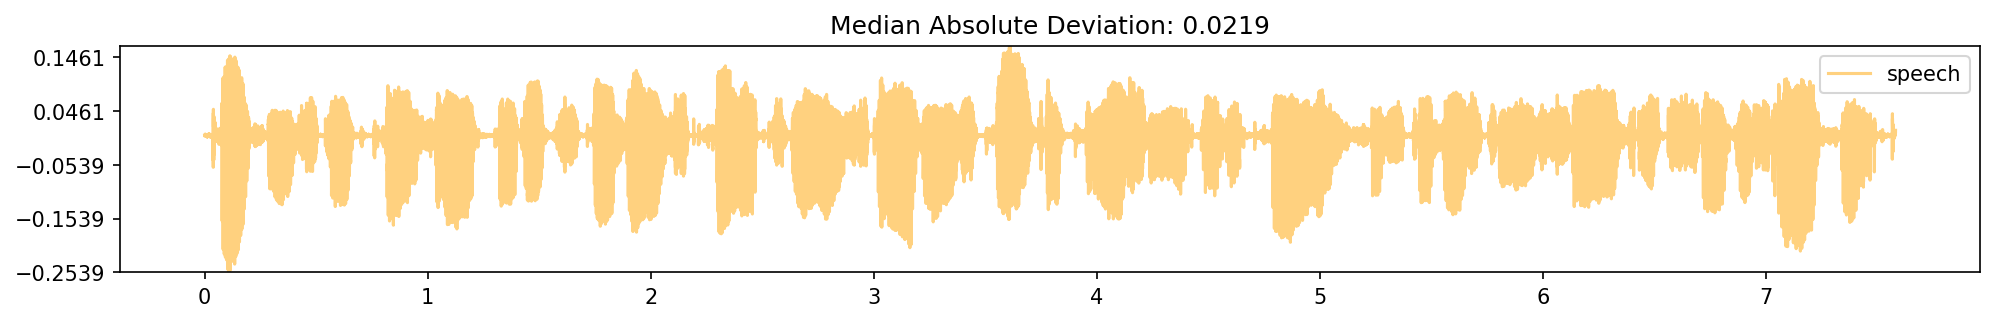

In [ ]:
# plotting waveforms for full audio signal, silences and speech

from scipy.stats import median_absolute_deviation 

for file_i in files:
  print(file_i)
  path_to_wav = input_dir+file_i
  OWN_FILE = {'audio': path_to_wav}
  waveform = RawAudio(sample_rate=16000)(OWN_FILE).data
  
  silence_segments = silence.get(file_i)
  speech_segments = speech.get(file_i)
  waveform_silence = concat_seconds(waveform, silence_segments, sr = sr)
  waveform_speech = concat_seconds(waveform, speech_segments, sr = sr)
  
  y0 = waveform.copy()
  y1 = waveform_silence.copy()
  y2 = waveform_speech.copy()

  
  
  figure(figsize=(16, 2), dpi=150)
  time0 = np.linspace(0, len(y0) / fs, num=len(y0))
  time1 = np.linspace(0, len(y1) / fs, num=len(y1))
  time2 = np.linspace(0, len(y2) / fs, num=len(y2))

  mad0 = np.round(median_absolute_deviation(y0),4)[0]
  mad1 = np.round(median_absolute_deviation(y1),4)
  mad2 = np.round(median_absolute_deviation(y2),4)

  max = np.max(y0)
  min = np.min(y0)
  
  plt.plot(time0,y0, color = 'gray', alpha = 0.5, label='full')
  plt.ylim((min, max))
  plt.yticks(np.arange(min,max, 0.1))
  plt.title(f'Median Absolute Deviation: {str(mad0)}')
  plt.legend()
  plt.show()
  display(Audio(data=y0.squeeze(), rate=16000, autoplay=False))
  

  figure(figsize=(16, 2), dpi=150)
  plt.plot(time1,y1, color = 'blue', alpha = 0.5, label='silence')
  plt.ylim((min, max))
  plt.yticks(np.arange(min,max, 0.1))
  plt.title(f'Median Absolute Deviation: {str(mad1)}')
  plt.legend()
  plt.show()
  display(Audio(data=y1.squeeze(), rate=16000, autoplay=False))

  figure(figsize=(16, 2), dpi=150)
  plt.plot(time2,y2, color = 'orange', alpha=0.5, label = 'speech')
  plt.ylim((min, max))
  plt.yticks(np.arange(min,max, 0.1))
  plt.title(f'Median Absolute Deviation: {str(mad2)}')
  plt.legend()
  plt.show()  
  display(Audio(data=y2.squeeze(), rate=16000, autoplay=False))
  # Audio(data=waveform_silence.squeeze(), rate=sr)
  print('\n\n')
